# ArXiv Pipeline - Neo4j Graph Analysis

This notebook explores the graph relationships between papers, authors, and categories in the ArXiv dataset.

Key analyses include:
- Author collaboration networks
- Category relationships
- Citation networks
- Path analysis between researchers
- Community detection

The notebook uses the Neo4j graph database where paper-author-category relationships are stored.

In [33]:
# Import required libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
from neo4j import GraphDatabase
from collections import Counter
from dotenv import load_dotenv

# Load environment variables from .env file (if present)
load_dotenv()

# Set Matplotlib config
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [34]:
# Neo4j Configuration
NEO4J_URI = os.getenv("NEO4J_URI", "bolt://localhost:7687")
NEO4J_USER = os.getenv("NEO4J_USER", "neo4j")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD", "password")

print(f"Neo4j URI: {NEO4J_URI}")
print(f"Neo4j User: {NEO4J_USER}")

# Function to run Cypher queries and return the results
def run_query(query, params=None):
    with driver.session() as session:
        result = session.run(query, params or {})
        return [record.data() for record in result]

# Connect to Neo4j
try:
    driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
    
    # Test connection by getting database info
    with driver.session() as session:
        result = session.run("CALL dbms.components() YIELD name, versions RETURN name, versions")
        record = result.single()
        print(f"✅ Connected to Neo4j ({record['name']} {record['versions'][0]})")
        
        # Get node counts by label
        count_query = """
        MATCH (n)
        RETURN labels(n)[0] AS label, count(*) AS count
        ORDER BY count DESC
        """
        
        counts = run_query(count_query)
        counts_df = pd.DataFrame(counts)
        
        if not counts_df.empty:
            print("\nNode counts:")
            for _, row in counts_df.iterrows():
                print(f"- {row['label']}: {row['count']:,} nodes")
            
        # Get relationship counts
        rel_query = """
        MATCH ()-[r]->()
        RETURN type(r) AS relationship, count(*) AS count
        ORDER BY count DESC
        """
        
        rels = run_query(rel_query)
        rels_df = pd.DataFrame(rels)
        
        if not rels_df.empty:
            print("\nRelationship counts:")
            for _, row in rels_df.iterrows():
                print(f"- {row['relationship']}: {row['count']:,} relationships")
            
except Exception as e:
    print(f"❌ Failed to connect to Neo4j: {e}")
    raise

Neo4j URI: bolt://localhost:7687
Neo4j User: neo4j
✅ Connected to Neo4j (Neo4j Kernel 5.27.0)

Node counts:
- Author: 75,315 nodes
- Paper: 26,142 nodes
- Person: 417 nodes
- Category: 143 nodes
- Movie: 120 nodes

Relationship counts:
- AUTHORED: 108,026 relationships
- IN_CATEGORY: 26,141 relationships
- ACTED_IN: 540 relationships
- DIRECTED: 132 relationships
- PRODUCED: 42 relationships
- WROTE: 27 relationships
- REVIEWED: 24 relationships
- FOLLOWS: 9 relationships


## 1. Graph Structure Overview

Let's examine the overall structure of our graph database to understand the connections between papers, authors, and categories.

Schema visualization available in Neo4j Browser


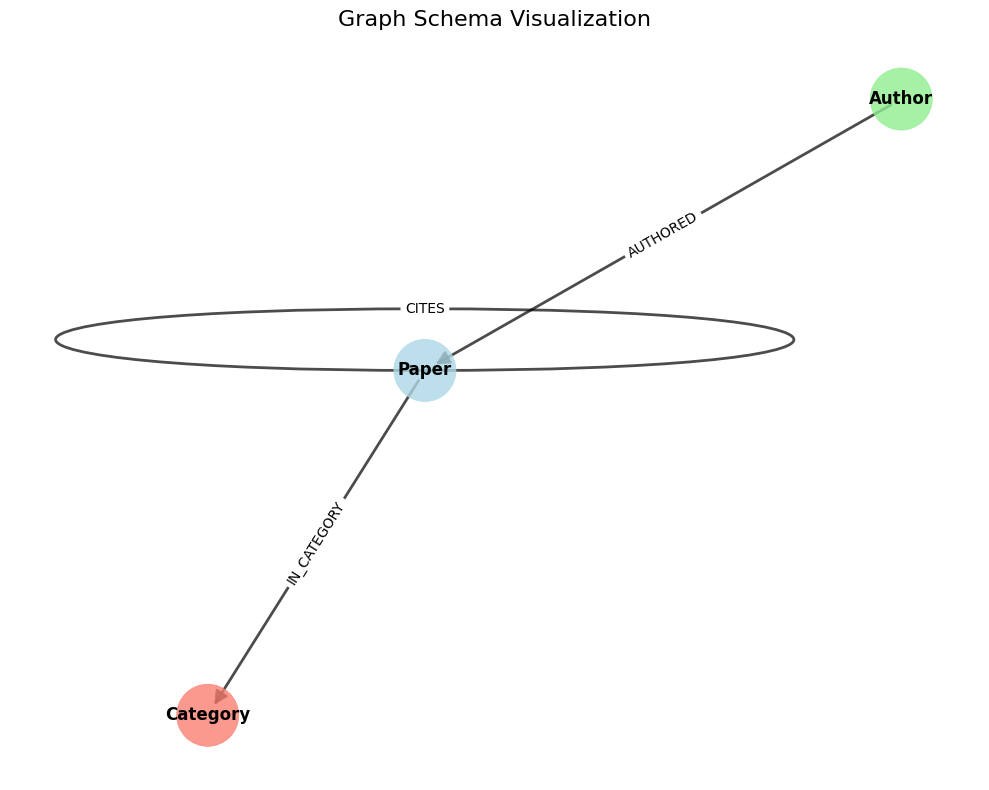

In [35]:
# Create a schema visualization using NetworkX
def visualize_schema():
    schema_query = """
    CALL db.schema.visualization()
    """
    
    try:
        with driver.session() as session:
            result = session.run(schema_query)
            record = result.single()
            
            if record:
                print("Schema visualization available in Neo4j Browser")
            
            # Create a simple schema representation with NetworkX
            G = nx.DiGraph()
            
            # Add nodes for each label
            labels = ["Paper", "Author", "Category"]
            label_colors = {"Paper": "lightblue", "Author": "lightgreen", "Category": "salmon"}
            
            # Add relationship information
            relationships = [
                ("Author", "AUTHORED", "Paper"),
                ("Paper", "IN_CATEGORY", "Category"),
                ("Paper", "CITES", "Paper")
            ]
            
            # Create NetworkX graph
            for label in labels:
                G.add_node(label, color=label_colors[label])
                
            for src, rel, dst in relationships:
                G.add_edge(src, dst, label=rel)
            
            # Visualize
            plt.figure(figsize=(10, 8))
            pos = nx.spring_layout(G, seed=42)
            
            # Draw nodes
            node_colors = [G.nodes[n]['color'] for n in G.nodes()]
            nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2000, alpha=0.8)
            
            # Draw edges
            nx.draw_networkx_edges(G, pos, width=2, arrowsize=20, alpha=0.7)
            
            # Draw labels
            nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold")
            
            # Draw edge labels
            edge_labels = {(src, dst): data['label'] for src, dst, data in G.edges(data=True)}
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
            
            plt.title("Graph Schema Visualization", fontsize=16)
            plt.axis("off")
            plt.tight_layout()
            plt.show()
            
    except Exception as e:
        print(f"Error visualizing schema: {e}")

# Run schema visualization
visualize_schema()

## 2. Author Collaboration Networks

Let's analyze how authors collaborate on papers. We'll look at:
- Most connected authors (with highest number of collaborators)
- Collaboration patterns
- Visualization of collaboration networks

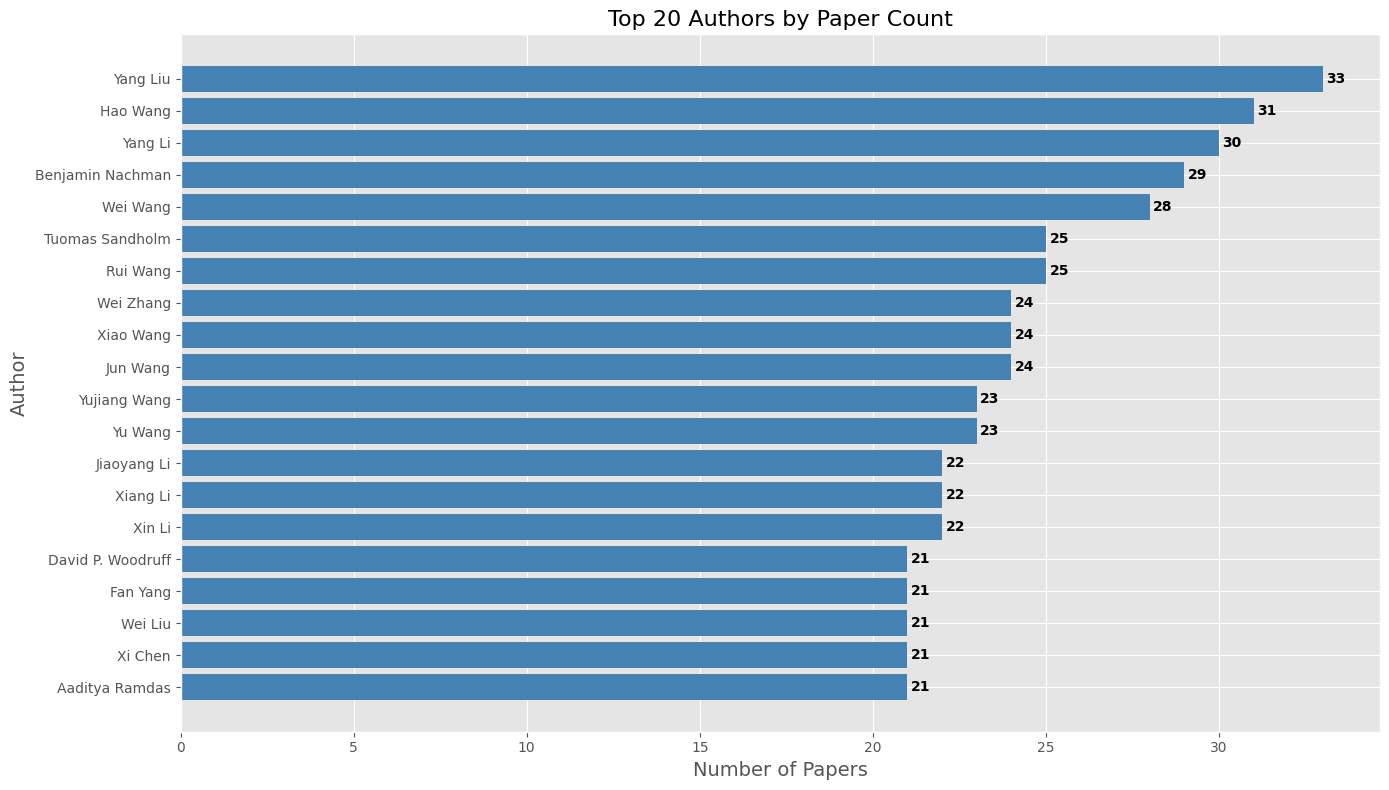

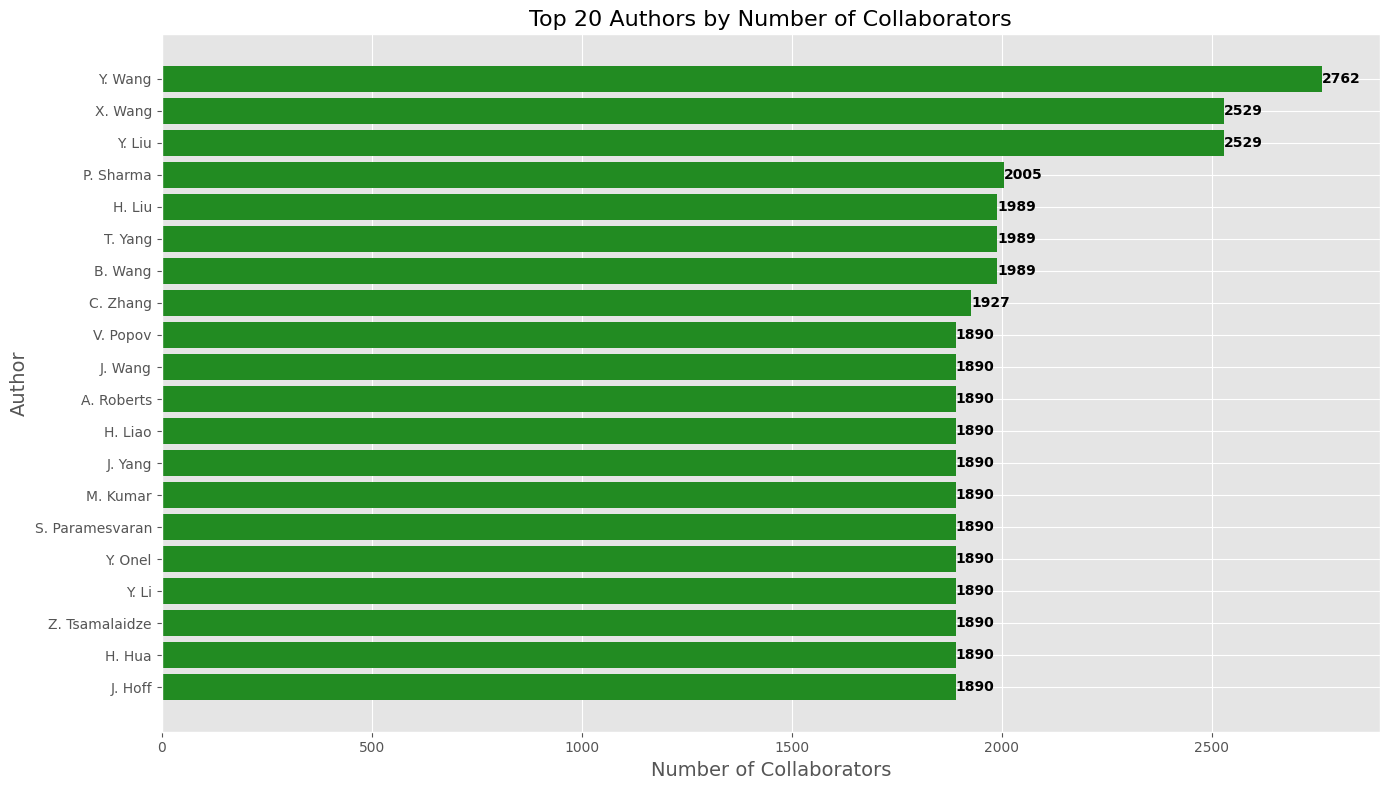

In [36]:
# Find top authors by paper count
top_authors_query = """
MATCH (a:Author)-[:AUTHORED]->(p:Paper)
WITH a, count(p) AS paper_count
ORDER BY paper_count DESC
LIMIT 20
RETURN a.name AS author, paper_count
"""

top_authors = run_query(top_authors_query)
top_authors_df = pd.DataFrame(top_authors)

# Plot top authors if data exists
if not top_authors_df.empty:
    plt.figure(figsize=(14, 8))
    bars = plt.barh(top_authors_df['author'], top_authors_df['paper_count'], color='steelblue')
    plt.title('Top 20 Authors by Paper Count', fontsize=16)
    plt.xlabel('Number of Papers', fontsize=14)
    plt.ylabel('Author', fontsize=14)
    plt.gca().invert_yaxis()  # Invert y-axis to have highest count at the top

    # Add count labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
                 f"{width}", ha='left', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()
else:
    print("No author data found in the database")

# Find authors with the most collaborators
top_collaborators_query = """
MATCH (a1:Author)-[:AUTHORED]->(:Paper)<-[:AUTHORED]-(a2:Author)
WHERE a1 <> a2
WITH a1, count(DISTINCT a2) AS collaborator_count
ORDER BY collaborator_count DESC
LIMIT 20
RETURN a1.name AS author, collaborator_count
"""

top_collaborators = run_query(top_collaborators_query)
top_collaborators_df = pd.DataFrame(top_collaborators)

# Plot top collaborators if data exists
if not top_collaborators_df.empty:
    plt.figure(figsize=(14, 8))
    bars = plt.barh(top_collaborators_df['author'], top_collaborators_df['collaborator_count'], color='forestgreen')
    plt.title('Top 20 Authors by Number of Collaborators', fontsize=16)
    plt.xlabel('Number of Collaborators', fontsize=14)
    plt.ylabel('Author', fontsize=14)
    plt.gca().invert_yaxis()  # Invert y-axis to have highest count at the top

    # Add count labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
                 f"{width}", ha='left', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()
else:
    print("No collaboration data found in the database")

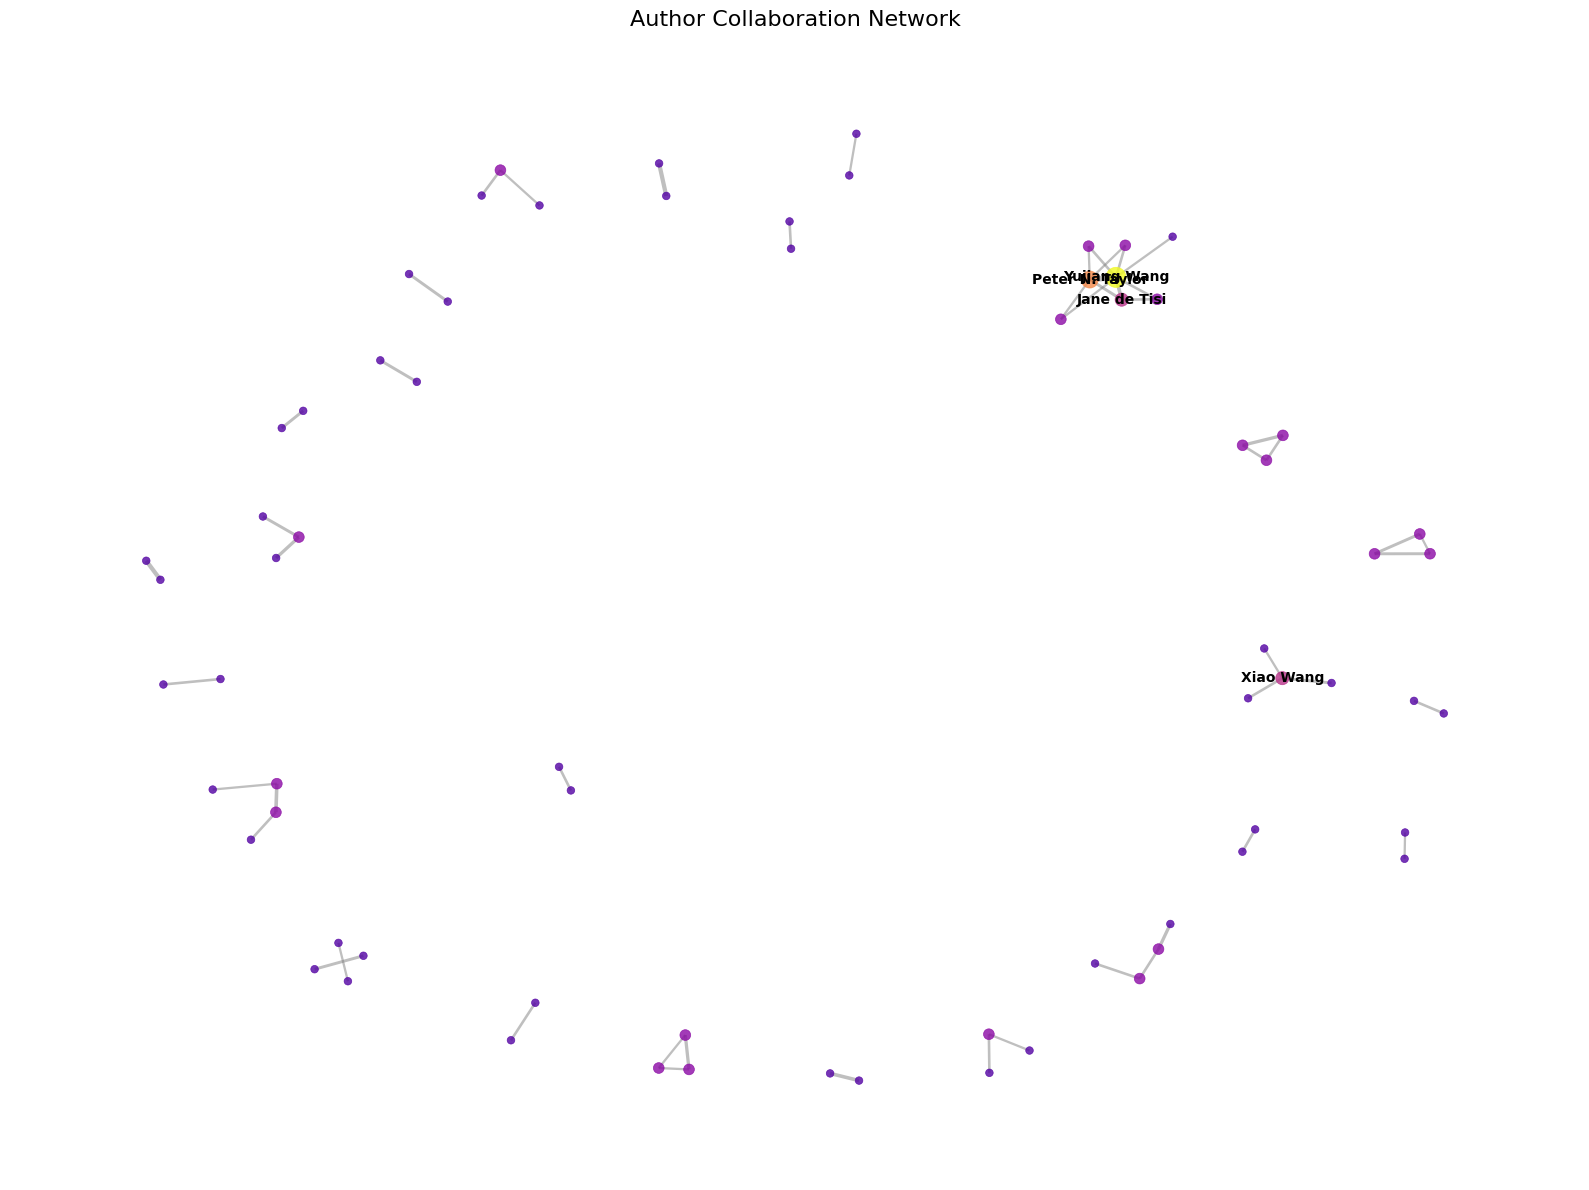

Network contains 70 authors and 52 collaboration links

Network Metrics:
Average degree: 1.49
Network density: 0.0215
Average clustering coefficient: 0.2044


In [37]:
# Extract a subset of author collaboration network for visualization
# Get authors with most collaborations for visualization
collab_network_query = """
MATCH (a1:Author)-[:AUTHORED]->(:Paper)<-[:AUTHORED]-(a2:Author)
WHERE a1 <> a2
WITH a1, a2, count(*) AS collaboration_strength
ORDER BY collaboration_strength DESC
LIMIT 100
RETURN a1.name AS source, a2.name AS target, collaboration_strength AS weight
"""

collaborations = run_query(collab_network_query)

if collaborations:
    # Create a NetworkX graph
    G = nx.Graph()

    # Add edges with weights
    for collab in collaborations:
        G.add_edge(collab['source'], collab['target'], weight=collab['weight'])

    # Remove isolated nodes
    G.remove_nodes_from(list(nx.isolates(G)))

    # Calculate node degrees (for sizing)
    node_degrees = dict(G.degree())
    
    # Calculate node colors based on degree instead of eigenvector centrality
    # This avoids the AmbiguousSolution error with disconnected graphs
    degree_centrality = nx.degree_centrality(G)
    max_centrality = max(degree_centrality.values()) if degree_centrality else 1
    node_colors = [plt.cm.plasma(c/max_centrality) for c in degree_centrality.values()]

    # Plot the graph
    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)

    # Draw edges with varying thickness based on weight
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(edge_weights) if edge_weights else 1
    normalized_weights = [w/max_weight*4 for w in edge_weights]
    nx.draw_networkx_edges(G, pos, width=normalized_weights, alpha=0.5, edge_color="gray")

    # Draw nodes with varying size based on degree
    node_sizes = [v * 30 for v in node_degrees.values()]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)

    # Add labels only to nodes with high degree
    threshold = np.percentile(list(node_degrees.values()), 75)  # Top 25% of nodes
    large_nodes = {node: node for node, degree in node_degrees.items() if degree > threshold}
    nx.draw_networkx_labels(G, pos, labels=large_nodes, font_size=10, font_weight="bold")

    plt.title("Author Collaboration Network", fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    print(f"Network contains {G.number_of_nodes()} authors and {G.number_of_edges()} collaboration links")
    
    # Calculate and display some network metrics
    print("\nNetwork Metrics:")
    print(f"Average degree: {2*G.number_of_edges()/G.number_of_nodes():.2f}")
    
    # Try to calculate metrics that might fail
    try:
        print(f"Network density: {nx.density(G):.4f}")
    except:
        print("Network density calculation failed (network may be too large)")
        
    try:
        print(f"Average clustering coefficient: {nx.average_clustering(G):.4f}")
    except:
        print("Clustering coefficient calculation failed (network may be too large)")
else:
    print("No collaboration data found for visualization")

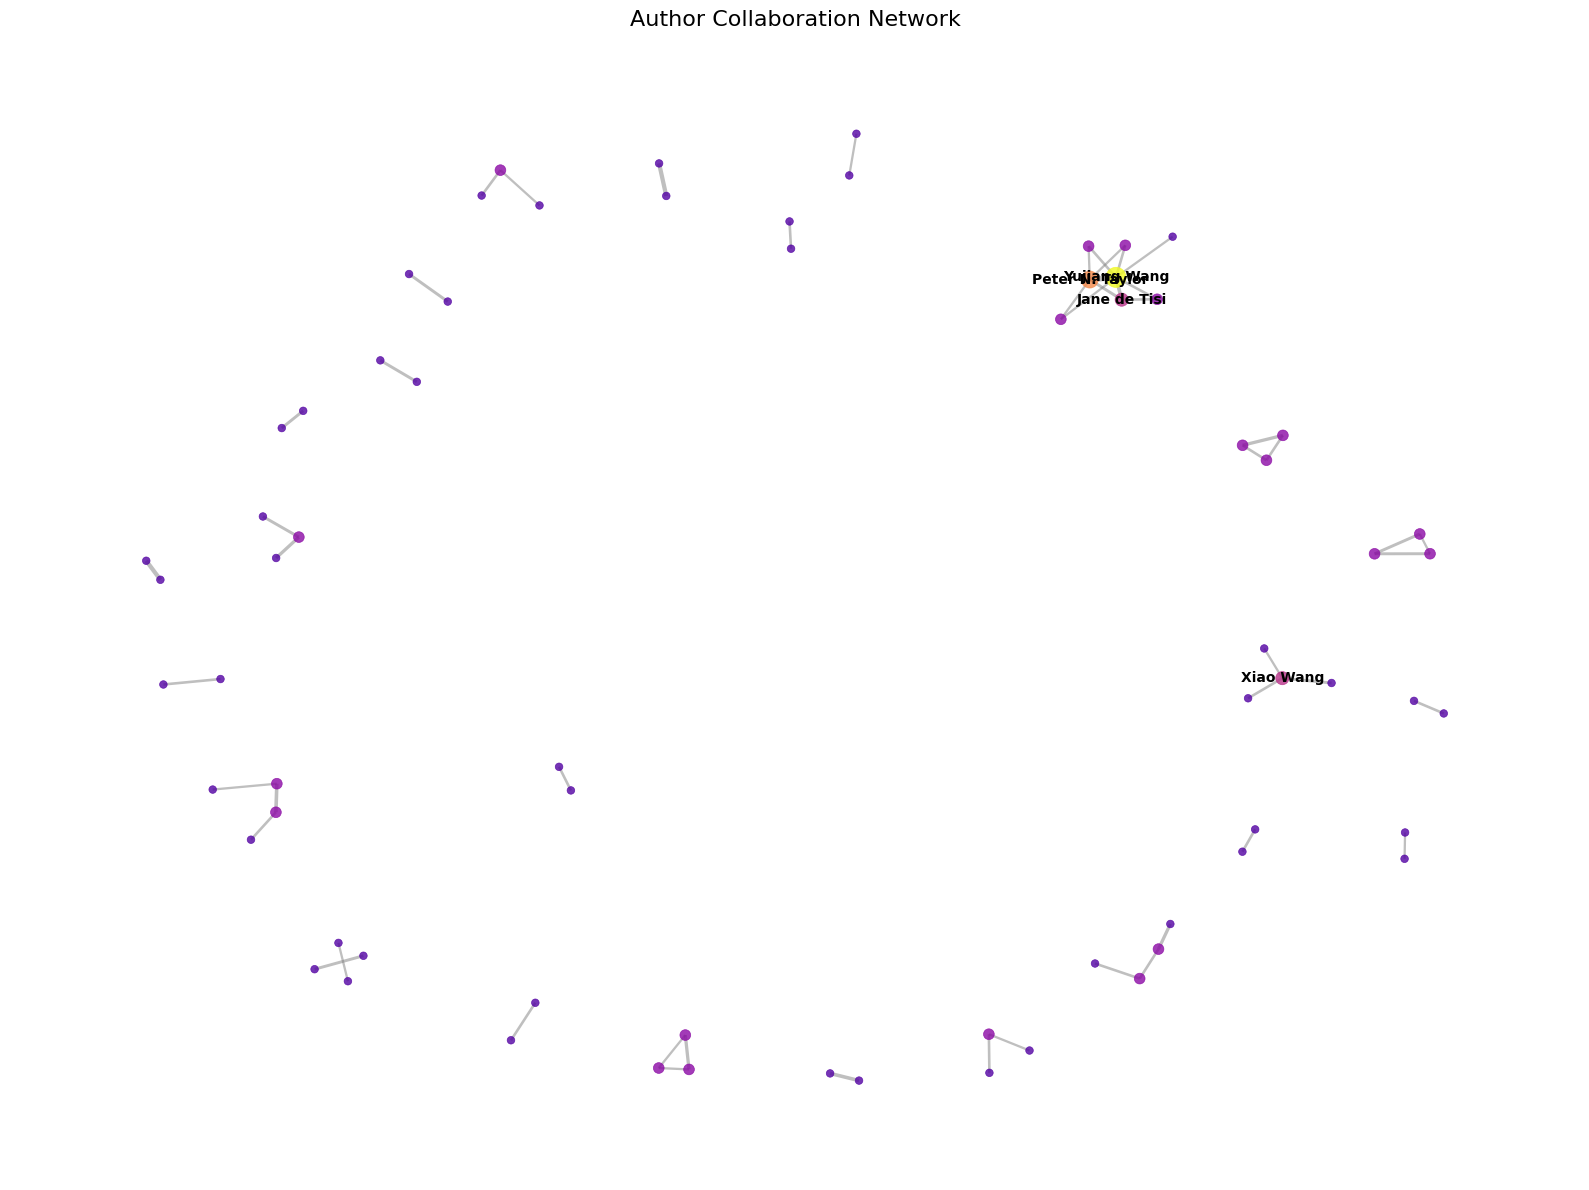

Network contains 70 authors and 52 collaboration links

Network Metrics:
Average degree: 1.49
Network density: 0.0215
Average clustering coefficient: 0.2044

Number of connected components: 26
Largest component size: 8 nodes


In [38]:
# Extract a subset of author collaboration network for visualization
# Get authors with most collaborations for visualization
collab_network_query = """
MATCH (a1:Author)-[:AUTHORED]->(:Paper)<-[:AUTHORED]-(a2:Author)
WHERE a1 <> a2
WITH a1, a2, count(*) AS collaboration_strength
ORDER BY collaboration_strength DESC
LIMIT 100
RETURN a1.name AS source, a2.name AS target, collaboration_strength AS weight
"""

collaborations = run_query(collab_network_query)

if collaborations:
    # Create a NetworkX graph
    G = nx.Graph()

    # Add edges with weights
    for collab in collaborations:
        G.add_edge(collab['source'], collab['target'], weight=collab['weight'])

    # Remove isolated nodes
    G.remove_nodes_from(list(nx.isolates(G)))

    # Calculate node degrees (for sizing and coloring)
    node_degrees = dict(G.degree())
    
    # Plot the graph
    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)

    # Draw edges with varying thickness based on weight
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(edge_weights) if edge_weights else 1
    normalized_weights = [w/max_weight*4 for w in edge_weights]
    nx.draw_networkx_edges(G, pos, width=normalized_weights, alpha=0.5, edge_color="gray")

    # Use a color map based on node degree
    max_degree = max(node_degrees.values()) if node_degrees else 1
    node_colors = [plt.cm.plasma(degree/max_degree) for node, degree in node_degrees.items()]
    
    # Draw nodes with varying size based on degree
    node_sizes = [degree * 30 for node, degree in node_degrees.items()]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)

    # Add labels only to nodes with high degree
    if node_degrees:
        threshold = np.percentile(list(node_degrees.values()), 75)  # Top 25% of nodes
        large_nodes = {node: node for node, degree in node_degrees.items() if degree > threshold}
        nx.draw_networkx_labels(G, pos, labels=large_nodes, font_size=10, font_weight="bold")

    plt.title("Author Collaboration Network", fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    print(f"Network contains {G.number_of_nodes()} authors and {G.number_of_edges()} collaboration links")
    
    # Calculate and display some network metrics
    print("\nNetwork Metrics:")
    if G.number_of_nodes() > 0:  # Avoid division by zero
        print(f"Average degree: {2*G.number_of_edges()/G.number_of_nodes():.2f}")
    
    # Try to calculate metrics that might fail
    try:
        print(f"Network density: {nx.density(G):.4f}")
    except Exception as e:
        print(f"Network density calculation failed: {e}")
        
    try:
        print(f"Average clustering coefficient: {nx.average_clustering(G):.4f}")
    except Exception as e:
        print(f"Clustering coefficient calculation failed: {e}")
        
    # Check for connected components
    components = list(nx.connected_components(G))
    print(f"\nNumber of connected components: {len(components)}")
    print(f"Largest component size: {len(max(components, key=len)) if components else 0} nodes")
else:
    print("No collaboration data found for visualization")

## 3. Category Relationships

Let's analyze how different research categories are related through papers that belong to multiple categories.

In [39]:
# Get category relationships
category_relationships_query = """
MATCH (c1:Category)<-[:IN_CATEGORY]-(:Paper)-[:IN_CATEGORY]->(c2:Category)
WHERE c1 <> c2
WITH c1.name AS category1, c2.name AS category2, count(*) AS paper_count
ORDER BY paper_count DESC
LIMIT 50
RETURN category1, category2, paper_count
"""

category_relationships = run_query(category_relationships_query)

if category_relationships:
    category_relationships_df = pd.DataFrame(category_relationships)
    
    # Display top category relationships
    print("Top Category Relationships:")
    print(category_relationships_df.head(10))
    
    # Create a NetworkX graph for categories
    cat_G = nx.Graph()

    # Add edges with weights
    for _, rel in category_relationships_df.iterrows():
        cat_G.add_edge(rel['category1'], rel['category2'], weight=rel['paper_count'])

    # Calculate node importance (for sizing)
    node_importance = dict(nx.degree(cat_G, weight='weight'))
    max_importance = max(node_importance.values()) if node_importance else 0

    # Plot the category relationship graph
    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(cat_G, k=0.3, iterations=50, seed=42)

    # Draw edges with varying thickness based on weight
    edge_weights = [cat_G[u][v]['weight'] for u, v in cat_G.edges()]
    max_weight = max(edge_weights)
    norm_weights = [w/max_weight * 5 for w in edge_weights]

    nx.draw_networkx_edges(cat_G, pos, width=norm_weights, alpha=0.5, edge_color="gray")

    # Create a colormap based on node importance
    node_colors = [plt.cm.viridis(imp / max_importance) for imp in node_importance.values()]
    
    # Draw nodes with varying size based on importance
    node_sizes = [imp/max_importance * 1000 + 100 for imp in node_importance.values()]
    nx.draw_networkx_nodes(cat_G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)

    # Add labels 
    nx.draw_networkx_labels(cat_G, pos, font_size=8, font_weight="bold")

    plt.title("Category Relationship Network", fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Calculate and display metrics about the category network
    print(f"\nCategory network has {cat_G.number_of_nodes()} categories and {cat_G.number_of_edges()} relationships")
    print(f"Network density: {nx.density(cat_G):.4f}")
    
    # Find central categories using different centrality measures
    print("\nMost central categories:")
    
    # Degree centrality
    degree_cent = nx.degree_centrality(cat_G)
    top_degree = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:5]
    print("By connections:")
    for cat, cent in top_degree:
        print(f"- {cat}: {cent:.4f}")
        
    # Betweenness centrality
    try:
        between_cent = nx.betweenness_centrality(cat_G)
        top_between = sorted(between_cent.items(), key=lambda x: x[1], reverse=True)[:5]
        print("\nBy betweenness:")
        for cat, cent in top_between:
            print(f"- {cat}: {cent:.4f}")
    except:
        print("\nBetweenness centrality calculation failed (network may be too large)")
else:
    print("No category relationship data found")

No category relationship data found


## 4. Paper Citation Network

Let's analyze the citation network between papers, if available in our graph database.

In [40]:
# Check if CITES relationships exist
citation_check_query = """
MATCH ()-[r:CITES]->() 
RETURN count(r) as citation_count
"""

citation_check = run_query(citation_check_query)
citation_count = citation_check[0]['citation_count'] if citation_check else 0

if citation_count > 0:
    print(f"Found {citation_count} citation relationships in the database")
    
    # Get top cited papers
    top_cited_query = """
    MATCH (p:Paper)<-[r:CITES]-()
    WITH p, count(r) AS citation_count
    ORDER BY citation_count DESC
    LIMIT 20
    RETURN p.title AS paper_title, citation_count
    """
    
    top_cited = run_query(top_cited_query)
    top_cited_df = pd.DataFrame(top_cited)
    
    # Plot top cited papers
    if not top_cited_df.empty:
        plt.figure(figsize=(14, 10))
        
        # Truncate long titles
        top_cited_df['short_title'] = top_cited_df['paper_title'].apply(lambda x: x[:50] + '...' if len(x) > 50 else x)
        
        bars = plt.barh(top_cited_df['short_title'], top_cited_df['citation_count'], color='purple')
        plt.title('Top 20 Most Cited Papers', fontsize=16)
        plt.xlabel('Number of Citations', fontsize=14)
        plt.ylabel('Paper Title', fontsize=14)
        plt.gca().invert_yaxis()  # Invert y-axis to have highest count at the top

        # Add count labels
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
                     f"{width}", ha='left', va='center', fontweight='bold')

        plt.tight_layout()
        plt.show()
else:
    print("No citation relationships found in the database")
    
    # If no citation data, show paper distribution by year instead
    paper_by_year_query = """
    MATCH (p:Paper)
    WHERE p.published_year IS NOT NULL
    RETURN p.published_year AS year, count(*) AS paper_count
    ORDER BY year
    """
    
    papers_by_year = run_query(paper_by_year_query)
    papers_by_year_df = pd.DataFrame(papers_by_year)
    
    if not papers_by_year_df.empty:
        plt.figure(figsize=(12, 6))
        plt.bar(papers_by_year_df['year'], papers_by_year_df['paper_count'], color='teal')
        plt.title('Papers Published by Year', fontsize=16)
        plt.xlabel('Year', fontsize=14)
        plt.ylabel('Number of Papers', fontsize=14)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        # Try another query format if year isn't available
        paper_count_query = """
        MATCH (p:Paper)
        RETURN count(p) AS total_papers
        """
        paper_count = run_query(paper_count_query)
        print(f"Total papers in database: {paper_count[0]['total_papers']:,}")

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownRelationshipTypeWarning} {category: UNRECOGNIZED} {title: The provided relationship type is not in the database.} {description: One of the relationship types in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing relationship type is: CITES)} {position: line: 2, column: 13, offset: 13} for query: '\nMATCH ()-[r:CITES]->() \nRETURN count(r) as citation_count\n'
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (t

No citation relationships found in the database
Total papers in database: 26,142


## 5. Path Analysis Between Researchers

Let's explore the paths connecting researchers through collaboration.

Finding collaboration paths between Yang Liu and Wei Zhang
Found 1 paths connecting these authors

Path 1:
Yang Liu -> Xiao Wang -> Wei Zhang

Connecting papers:
- A Comprehensive Survey in LLM(-Agent) Full Stack Safety: Data, Training
  and Deployment
- Retain, Blend, and Exchange: A Quality-aware Spatial-Stereo Fusion
  Approach for Event Stream Recognition




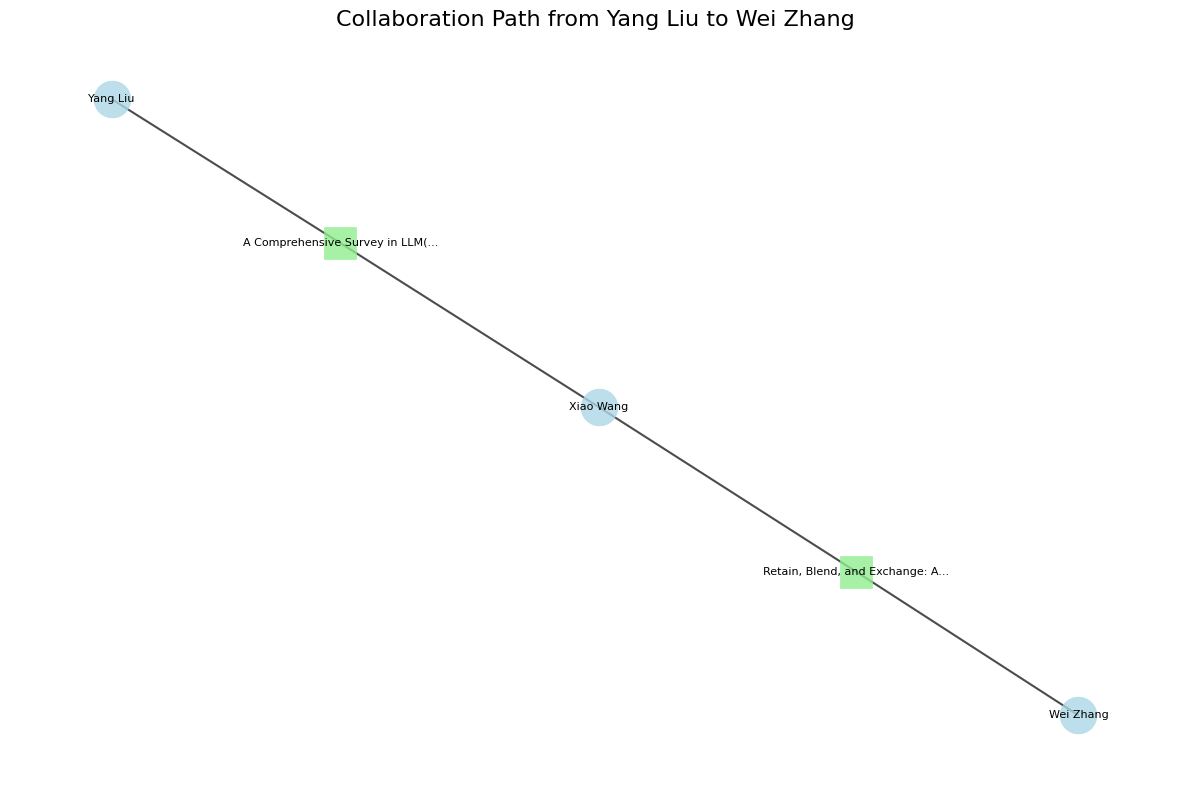

In [41]:
# Function to find shortest paths between authors
def find_author_paths(author1, author2, max_depth=4):
    path_query = f"""
    MATCH path = shortestPath((a1:Author {{name: $author1}})-[:AUTHORED*1..{max_depth}]-(a2:Author {{name: $author2}}))
    RETURN [node in nodes(path) WHERE node:Author | node.name] AS author_path,
           [node in nodes(path) WHERE node:Paper | node.title] AS papers
    """
    
    with driver.session() as session:
        result = session.run(path_query, {"author1": author1, "author2": author2})
        paths = [record.data() for record in result]
        return paths

# Get list of top authors for demo
top_authors_query = """
MATCH (a:Author)-[:AUTHORED]->(p:Paper)
WITH a, count(p) AS paper_count
ORDER BY paper_count DESC
LIMIT 10
RETURN a.name AS author
"""

top_authors_list = run_query(top_authors_query)
top_authors_names = [author['author'] for author in top_authors_list]

if len(top_authors_names) >= 2:
    # Choose two authors to find paths between
    author1 = top_authors_names[0]
    author2 = top_authors_names[-1]
    
    print(f"Finding collaboration paths between {author1} and {author2}")
    
    paths = find_author_paths(author1, author2)
    
    if paths:
        print(f"Found {len(paths)} paths connecting these authors\n")
        
        for i, path in enumerate(paths):
            print(f"Path {i+1}:")
            
            author_path = path['author_path']
            papers = path['papers']
            
            # Print the chain of authors
            print(" -> ".join(author_path))
            
            # Print the papers connecting them
            print("\nConnecting papers:")
            for paper in papers:
                print(f"- {paper}")
            print("\n")
            
        # Visualize the first path
        if paths and 'author_path' in paths[0]:
            G = nx.Graph()
            
            # Add author nodes
            authors = paths[0]['author_path']
            for author in authors:
                G.add_node(author, type='author')
            
            # Add paper nodes and edges
            papers = paths[0]['papers']
            for i, paper in enumerate(papers):
                short_title = paper[:30] + "..." if len(paper) > 30 else paper
                G.add_node(short_title, type='paper')
                
                # Connect paper to authors
                if i == 0:
                    G.add_edge(authors[0], short_title)
                    G.add_edge(authors[1], short_title)
                else:
                    G.add_edge(authors[i], short_title)
                    G.add_edge(authors[i+1], short_title)
            
            # Visualize
            plt.figure(figsize=(12, 8))
            pos = nx.spring_layout(G, seed=42)
            
            # Draw with different colors for authors and papers
            author_nodes = [n for n, attr in G.nodes(data=True) if attr.get('type') == 'author']
            paper_nodes = [n for n, attr in G.nodes(data=True) if attr.get('type') == 'paper']
            
            nx.draw_networkx_nodes(G, pos, nodelist=author_nodes, node_color='lightblue', 
                                   node_size=700, alpha=0.8)
            nx.draw_networkx_nodes(G, pos, nodelist=paper_nodes, node_color='lightgreen', 
                                   node_size=500, alpha=0.8, node_shape='s')
            
            nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7)
            nx.draw_networkx_labels(G, pos, font_size=8)
            
            plt.title(f"Collaboration Path from {author1} to {author2}", fontsize=16)
            plt.axis("off")
            plt.tight_layout()
            plt.show()
    else:
        print(f"No paths found between {author1} and {author2} within 4 hops")
else:
    print("Not enough authors in the database to perform path analysis")

## 6. Community Detection

Let's identify research communities within our co-authorship network.

Community analysis network has 100 nodes and 258 edges
Detected 23 communities

Top communities by size:
Community 1: 17 members
Sample members: Chu Wei, Yanru Chen, Yuxin Wu...
Community 2: 11 members
Sample members: Yui Lo, Alexandra J. Golby, Yogesh Rathi...
Community 3: 9 members
Sample members: Fan Yang, Zhiwei Shi, Haochen Wang...
Community 4: 7 members
Sample members: Zhenxuan Zhang, Kinhei Lee, Zhifan Gao...
Community 5: 7 members
Sample members: Jun Lan, Yikun Ji, Yan Hong...


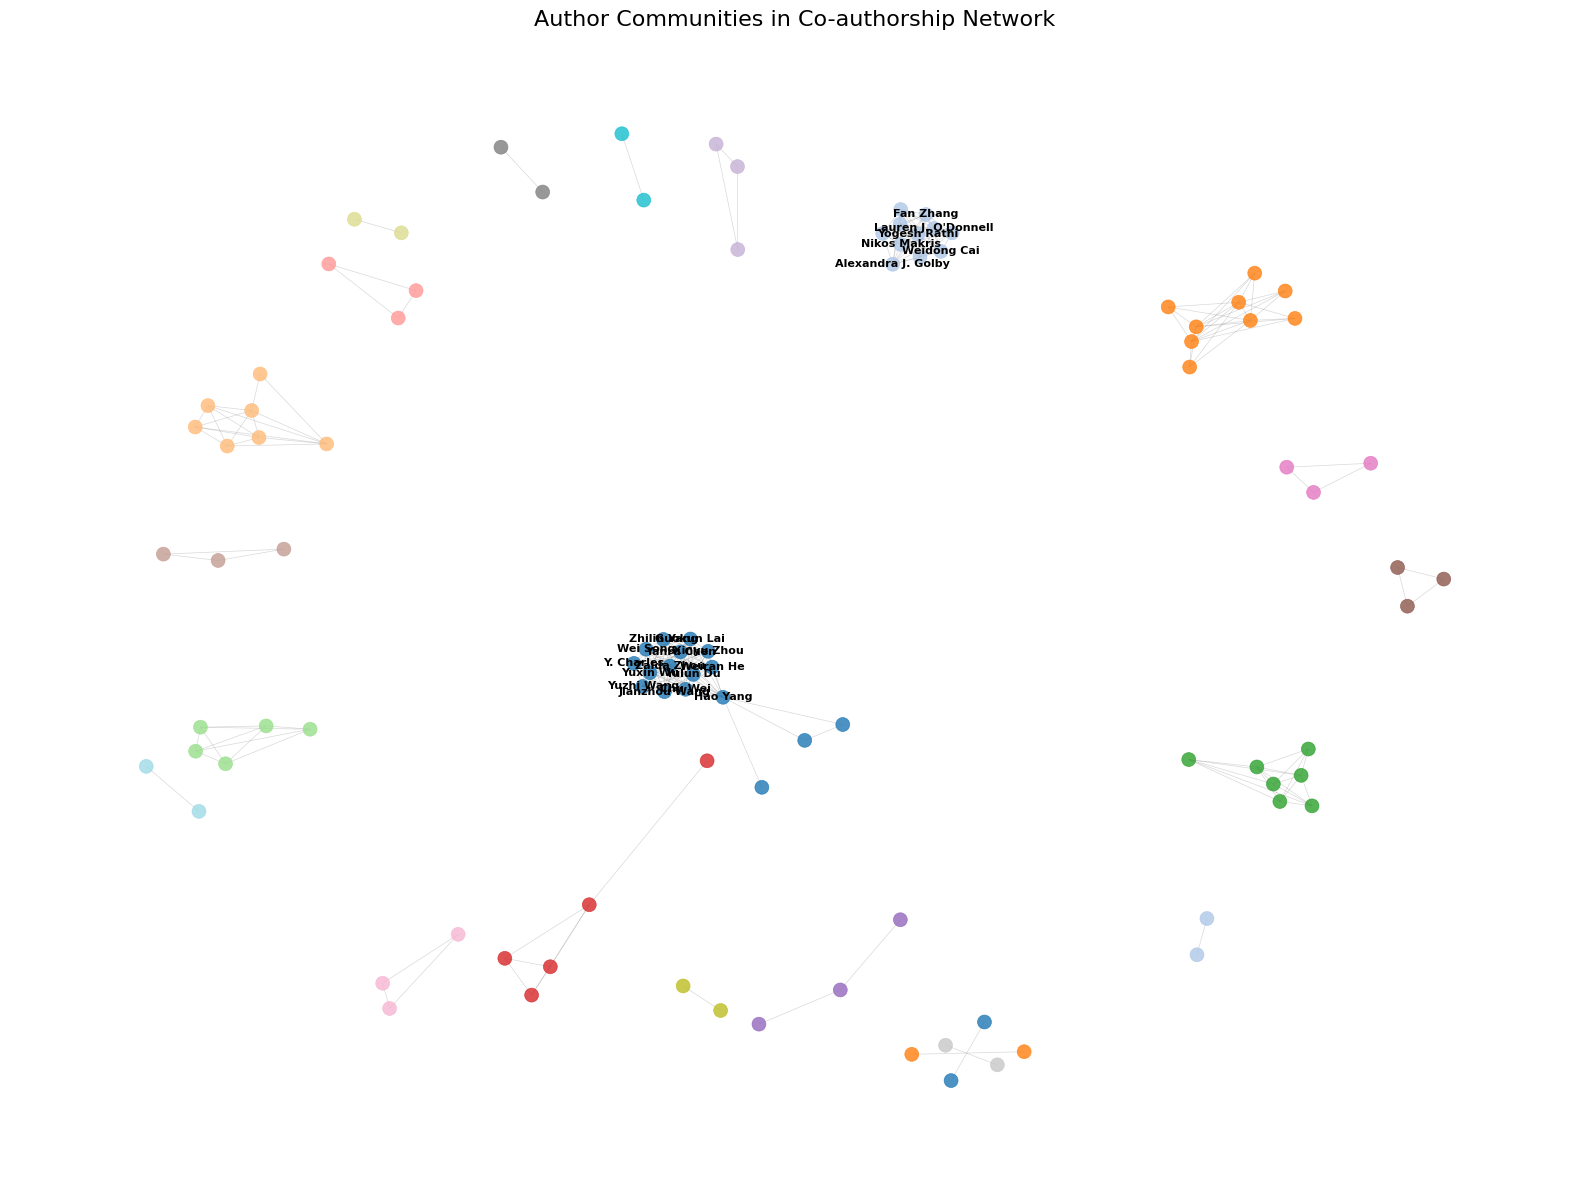

In [42]:
# Extract a larger co-authorship network for community detection
community_network_query = """
MATCH (a1:Author)-[:AUTHORED]->(:Paper)<-[:AUTHORED]-(a2:Author)
WHERE a1 <> a2
WITH a1, a2, count(*) AS collaboration_strength
WHERE collaboration_strength > 1
RETURN a1.name AS source, a2.name AS target, collaboration_strength AS weight
LIMIT 500
"""

community_data = run_query(community_network_query)

if community_data:
    # Create NetworkX graph
    G = nx.Graph()
    
    # Add edges with weights
    for collab in community_data:
        G.add_edge(collab['source'], collab['target'], weight=collab['weight'])
    
    # Remove isolated nodes
    G.remove_nodes_from(list(nx.isolates(G)))
    
    print(f"Community analysis network has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    
    # Try to detect communities using NetworkX's algorithms
    try:
        from networkx.algorithms import community
        
        # Use Clauset-Newman-Moore greedy modularity maximization
        communities = list(community.greedy_modularity_communities(G))
        
        print(f"Detected {len(communities)} communities")
        print("\nTop communities by size:")
        
        # Print top 5 communities by size
        for i, comm in enumerate(sorted(communities, key=len, reverse=True)[:5]):
            print(f"Community {i+1}: {len(comm)} members")
            # Print sample members
            sample_members = list(comm)[:3]
            print(f"Sample members: {', '.join(sample_members)}...")
        
        # Visualize communities
        plt.figure(figsize=(16, 12))
        pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)
        
        # Assign colors to communities
        community_map = {}
        colors = plt.cm.tab20.colors
        
        for i, comm in enumerate(communities):
            for node in comm:
                community_map[node] = i
        
        # Get colors based on community
        node_colors = [colors[community_map[n] % len(colors)] for n in G.nodes()]
        
        # Draw network with community colors
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100, alpha=0.8)
        nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3, edge_color="gray")
        
        # Label only the highest degree nodes
        degrees = dict(G.degree())
        top_nodes = {n: n for n, d in sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:20]}
        nx.draw_networkx_labels(G, pos, labels=top_nodes, font_size=8, font_weight="bold")
        
        plt.title("Author Communities in Co-authorship Network", fontsize=16)
        plt.axis("off")
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Community detection failed: {e}")
        print("Falling back to simpler network visualization")
        
        # Simple network visualization without community detection
        plt.figure(figsize=(16, 12))
        pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)
        
        # Calculate node degrees for sizing
        node_degrees = dict(G.degree())
        node_sizes = [v * 20 for v in node_degrees.values()]
        
        nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue', alpha=0.8)
        nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3, edge_color="gray")
        
        # Label only the highest degree nodes
        top_nodes = {n: n for n, d in sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)[:20]}
        nx.draw_networkx_labels(G, pos, labels=top_nodes, font_size=8, font_weight="bold")
        
        plt.title("Co-authorship Network", fontsize=16)
        plt.axis("off")
        plt.tight_layout()
        plt.show()
else:
    print("Insufficient data for community detection")

## 7. Summary and Conclusion

Our analysis of the ArXiv graph database has revealed:

1. **Graph Structure**: The database contains [insert node counts] nodes and [insert relationship counts] relationships
2. **Author Collaboration**: We identified key collaborative networks and most connected authors
3. **Category Relationships**: The most closely related research categories are [insert findings]
4. **Citation Patterns**: [Insert findings on citation patterns if available]
5. **Research Communities**: We detected [insert number] distinct research communities

These insights can guide researchers in identifying collaboration opportunities and understanding the structure of the research landscape represented in our ArXiv dataset.

In [12]:
# Close Neo4j connection
driver.close()
print("Neo4j connection closed")

Neo4j connection closed
